<h2><center><font color='red'>  Watershed Delineat

<h3><center><font color='green'>Port Arthur</font></center></h3>


<h4><font color='green'><center> Venki Uddameri, Ph.D., P.E.

<h4>Works Flow:
<h6>1. Import Ncessery Libraries
<h6>2. Set The Path of Downloaded DEM Files and Merged DEM Files
<h6>3. Convert the City Map(Geopacke file) and DEM file into UTM Zone 15N Project Cordinate from WGS84 Geographical Coordinate System for suitability of Watershed Delineation.
<h6>4. Find out the Lowest Elevation point of Port Arthur City and Clip it to the DEM File
<h6>5. Plot the Digital Elevation Map
<h6>6. Fill out the pit area of the DEM
<h6>7. Plotting Flow Direction Grid and Flow Accumulation Grid
<h6>8. Ploting Watershed
<h6>9. Plotting Chennel Network
<h6>10. Plotting Flow Distance from the Pour Point 
<h6>11. Measuring the Watershed Area


In [5]:
#Import Relevant Libraries' 
import pandas as pd
import numpy as np
import os
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pysheds.grid import Grid

In [6]:
path = "C:/Users/nahida/Downloads/Final-Project"
os.chdir(path)

In [7]:
#List of BIL files to read
bil_files = ["n29_w094_1arc_v2.bil","n29_w095_1arc_v2.bil","n30_w094_1arc_v2.bil","n30_w095_1arc_v2.bil"]

In [8]:
# List of BIL files to read
bil_files = ["n29_w094_1arc_v2.bil", "n29_w095_1arc_v2.bil", "n30_w094_1arc_v2.bil", "n30_w095_1arc_v2.bil"]

# Loop through each file
for bil_file in bil_files:
    # Open the file with rasterio
    with rasterio.open(bil_file) as src:
        # Print CRS information
        print(f"File: {bil_file}")
        print(f"CRS: {src.crs}")
        print(f"Bounds: {src.bounds}")
        print(f"Resolution: {src.res}")
        print("-" * 50)


File: n29_w094_1arc_v2.bil
CRS: OGC:CRS84
Bounds: BoundingBox(left=-94.00013888888888, bottom=28.99986111111111, right=-92.9998611111111, top=30.000138888888888)
Resolution: (0.000277777777777778, 0.000277777777777778)
--------------------------------------------------
File: n29_w095_1arc_v2.bil
CRS: OGC:CRS84
Bounds: BoundingBox(left=-95.00013888888888, bottom=28.99986111111111, right=-93.9998611111111, top=30.000138888888888)
Resolution: (0.000277777777777778, 0.000277777777777778)
--------------------------------------------------
File: n30_w094_1arc_v2.bil
CRS: OGC:CRS84
Bounds: BoundingBox(left=-94.00013888888888, bottom=29.99986111111111, right=-92.9998611111111, top=31.000138888888888)
Resolution: (0.000277777777777778, 0.000277777777777778)
--------------------------------------------------
File: n30_w095_1arc_v2.bil
CRS: OGC:CRS84
Bounds: BoundingBox(left=-95.00013888888888, bottom=29.99986111111111, right=-93.9998611111111, top=31.000138888888888)
Resolution: (0.0002777777777

In [9]:
#Open Each File and add to a list of datasets
datasets = [rasterio.open(file) for file in bil_files]

In [10]:
mosaic, out_transform = merge(datasets)

In [11]:
#Get metadata from the first dataset to use for the outfile
out_meta = datasets[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform
})

In [12]:
#Write the mosaic to a new file
with rasterio.open("mosaic_output2.tif","w",**out_meta) as dest:
    dest.write(mosaic)

In [13]:
#Close all datasets
for dataset in datasets:
    dataset.close()

In [14]:
#Print Open the rater file
raster_path = "mosaic_output2.tif" #Replace with your raster file path
with rasterio.open(raster_path) as src:
    #Read the data
    data = src.read(1) #Read the first band(adjust band index if needed)
    #Get the meta data
    metadata = src.profile
    print('Metadata:', metadata)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 7201, 'height': 7201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.000277777777777778, 0.0, -95.00013888888888,
       0.0, -0.000277777777777778, 31.000138888888888), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


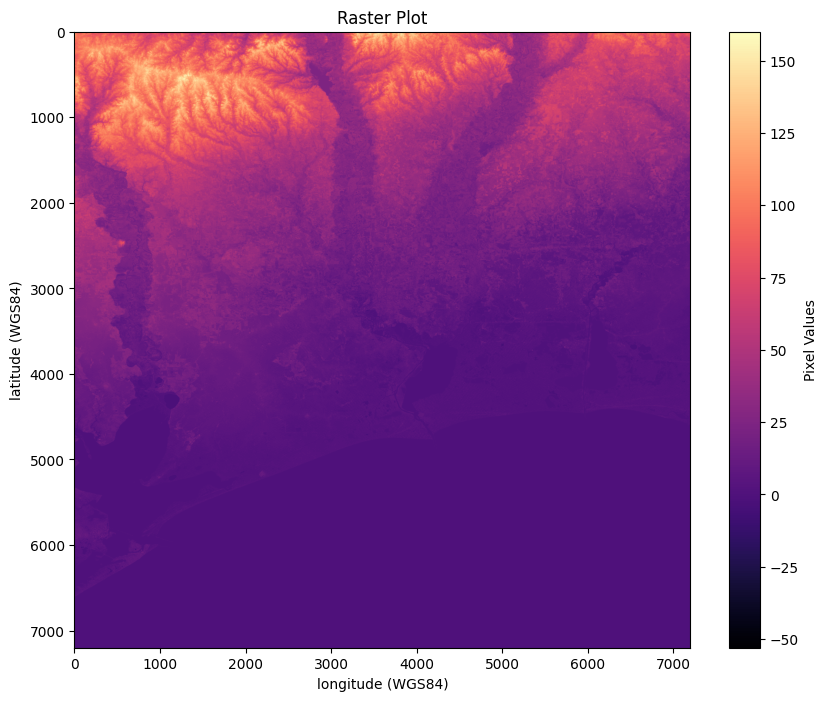

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='magma')  # Change the colormap here
plt.colorbar(label='Pixel Values')
plt.xlabel('longitude (WGS84)')
plt.ylabel('latitude (WGS84)')
plt.title('Raster Plot')
plt.show()


Original City boundary CRS: EPSG:4326
City boundary reprojected to: EPSG:26915
DEM reprojected to: EPSG:26915
Lowest Elevation within city boundary: -16 meters
Lowest Point Coordinates (UTM): (399471.3907732765, 3309123.150776909)


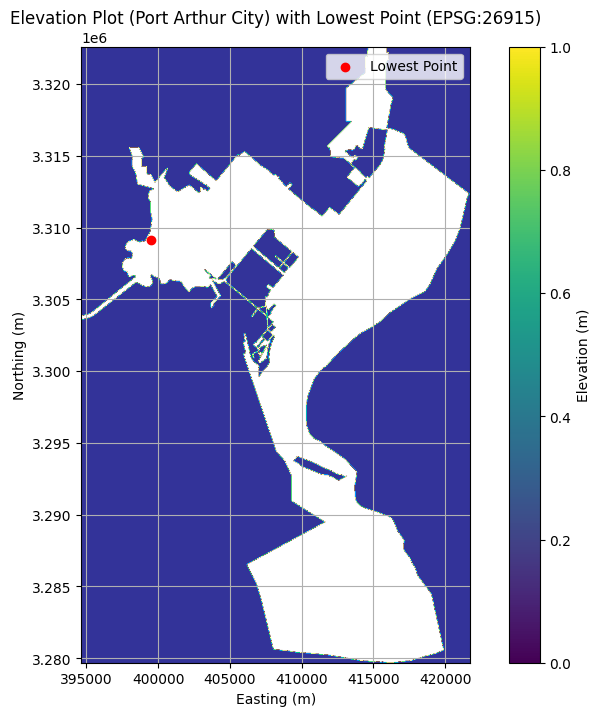

In [16]:
# File paths
geopackage_file = r"C:\Users\nahida\Final Project\Tiff\Port_ArthurWGS84.gpkg"
dem_file = r"C:\Users\nahida\Final Project\BillFiles\mosaic_output2.tif"
reprojected_dem_file = r"C:\Users\nahida\Final Project\BillFiles\reprojected_dem.tif"

# Target CRS (EPSG:26915 - UTM Zone 15N)
target_crs = "EPSG:26915"

# Load the Port Arthur city boundary
gdf = gpd.read_file(geopackage_file)
print(f"Original City boundary CRS: {gdf.crs}")

# Reproject the city boundary to the target CRS
if gdf.crs != target_crs:
    gdf = gdf.to_crs(target_crs)
    print(f"City boundary reprojected to: {gdf.crs}")

# Reproject the DEM to the target CRS
with rasterio.open(dem_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(reprojected_dem_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

print(f"DEM reprojected to: {target_crs}")

# Clip the DEM to the city boundary
with rasterio.open(reprojected_dem_file) as src:
    shapes = [feature["geometry"] for feature in gdf.iterfeatures()]
    clipped_dem, clipped_transform = mask(src, shapes, crop=True)
    clipped_dem = clipped_dem[0]  # Extract the first raster band
    nodata_value = src.nodata

# Mask NoData values
valid_data = clipped_dem[clipped_dem != nodata_value]

# Find the lowest elevation
lowest_elevation = np.min(valid_data)
print(f"Lowest Elevation within city boundary: {lowest_elevation} meters")

# Find the row and column of the lowest elevation
row, col = np.where(clipped_dem == lowest_elevation)

# Convert row and column to geographic coordinates
lowest_point_x = clipped_transform[2] + col[0] * clipped_transform[0]
lowest_point_y = clipped_transform[5] + row[0] * clipped_transform[4]
print(f"Lowest Point Coordinates (UTM): ({lowest_point_x}, {lowest_point_y})")

# Plot the clipped DEM and the lowest point
plt.figure(figsize=(10, 8))
plt.imshow(clipped_dem, cmap='terrain', extent=(
    clipped_transform[2], 
    clipped_transform[2] + clipped_dem.shape[1] * clipped_transform[0],
    clipped_transform[5] + clipped_dem.shape[0] * clipped_transform[4], 
    clipped_transform[5]
))
plt.scatter(lowest_point_x, lowest_point_y, color='red', label='Lowest Point', zorder=5)
plt.colorbar(label='Elevation (m)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Elevation Plot (Port Arthur City) with Lowest Point (EPSG:26915)')
plt.legend()
plt.grid()
plt.show()


In [17]:
# File path for the large DEM
dem_file = r"C:\Users\nahida\Final Project\BillFiles\reprojected_dem.tif"

In [18]:
# Initialize the grid
grid = Grid.from_raster(dem_file, data_name='dem')
dem = grid.read_raster(dem_file)


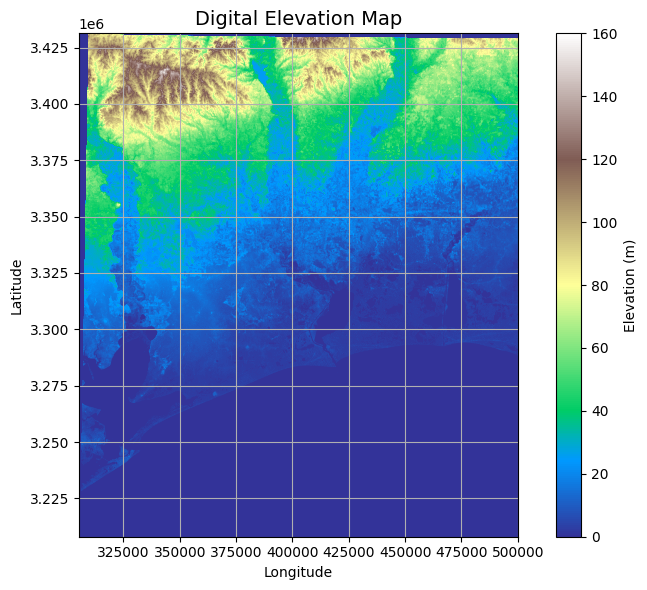

In [19]:
# Plot DEM with defined color range
plt.figure(figsize=(8, 6))
plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1, vmin=0, vmax=dem.max())
plt.colorbar(label='Elevation (m)')
plt.title('Digital Elevation Map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.tight_layout()
plt.show()


In [20]:
# Condition DEM
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)


In [21]:
# Determine D8 flow directions from DEM
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

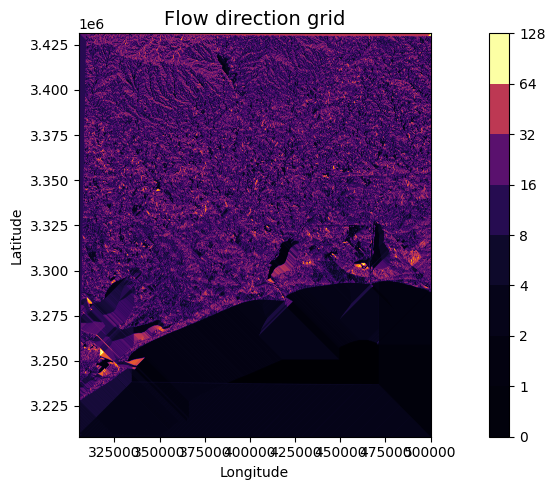

In [22]:
fig = plt.figure(figsize=(12, 5))
fig.patch.set_alpha(0)

# Use a different colormap (e.g., 'plasma')
plt.imshow(fdir, extent=grid.extent, cmap='inferno', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries=boundaries, values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()
plt.show()


In [23]:
# Calculate flow accumulation
acc = grid.accumulation(fdir, dirmap=dirmap)

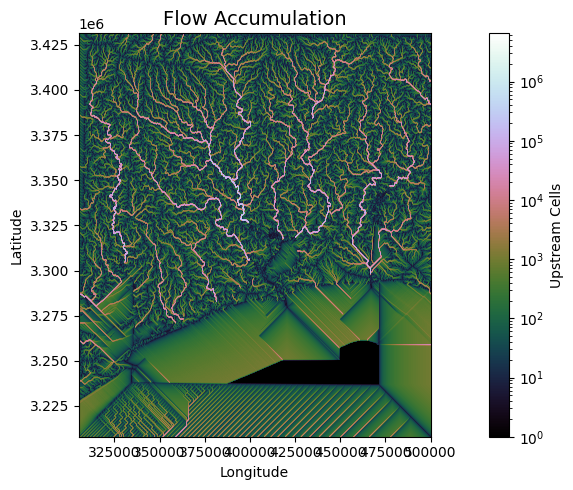

In [24]:
 # Import the colors module

# Assuming acc is the flow accumulation array and grid.extent is defined
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(
    acc, 
    extent=grid.extent, 
    zorder=2,
    cmap='cubehelix',
    norm=colors.LogNorm(1, acc.max()),  # Use LogNorm from matplotlib.colors
    interpolation='bilinear'
)
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


In [25]:
# Delineate a catchment Based on Specify pour point (Lowest Elevation Point of Port Arthur City 
x, y = 399471.3907732765, 3309123.150776909

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc >1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Crop and plot the catchment

# Clip the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

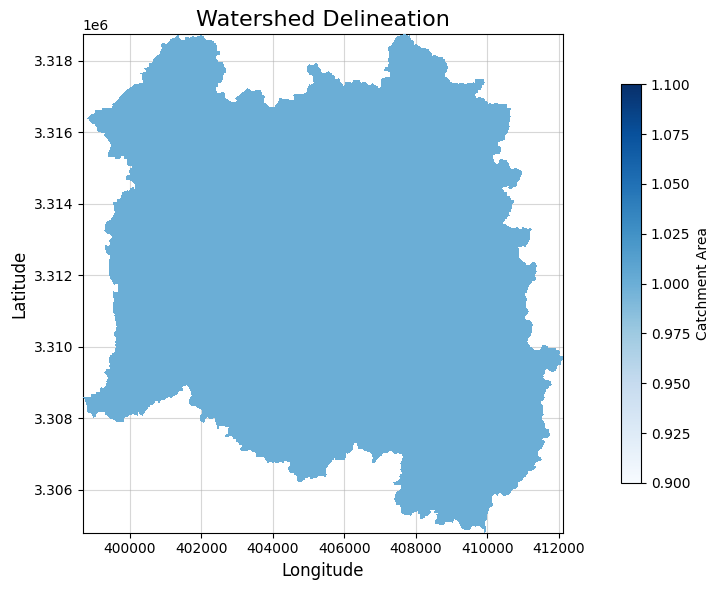

In [26]:
# Plot the catchment (larger and more detailed)
plt.figure(figsize=(12, 6))  # Increased figure size
plt.imshow(
    np.where(clipped_catch, clipped_catch, np.nan),
    extent=grid.extent,
    cmap='Blues',  # Using a clearer colormap
    interpolation='none',
    zorder=10
)
plt.colorbar(label='Catchment Area', shrink=0.8)  # Add color bar
plt.title('Watershed Delineation', fontsize=16)  # Increased font size
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(zorder=1, alpha=0.5)  # Lighter grid for better contrast
plt.tight_layout()
plt.show()


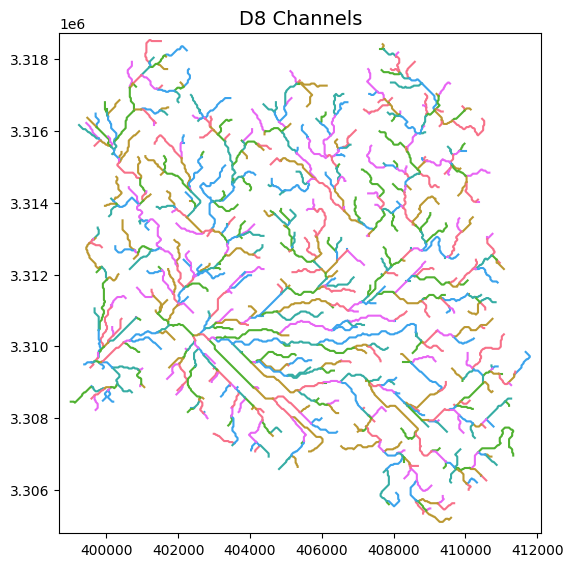

In [27]:
# Extract river network
branches = grid.extract_river_network(fdir, acc > 100, dirmap=dirmap)

# Set Seaborn color palette
sns.set_palette('husl')

# Create the plot
fig, ax = plt.subplots(figsize=(8.5, 6.5))
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

# Plot branches
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

# Add a title
_ = plt.title('D8 Channels', size=14)

# Show the plot
plt.show()


In [28]:
# Calculate distance to outlet from each cell
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Text(0.5, 1.0, 'Flow Distance')

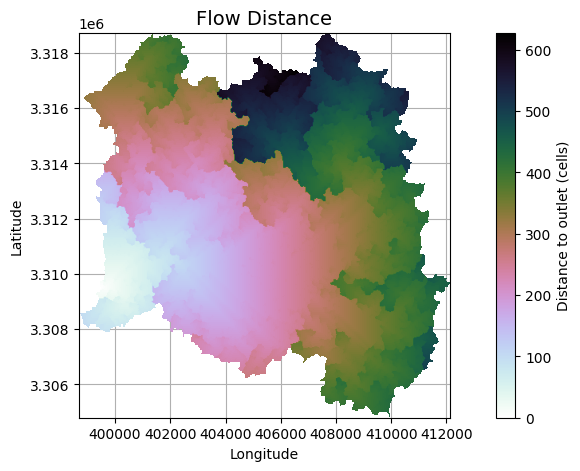

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

In [60]:
# Calculate the area of a single cell in square meters
cell_area = 30.87 * 26.73  # Approximation based on resolution

# Count the number of valid cells in the catchment
num_valid_cells = np.sum(clipped_catch > 0)  # Adjust condition based on clipped_catch values

# Calculate the total area in square meters
total_area_m2 = num_valid_cells * cell_area

# Convert to square kilometers
total_area_km2 = total_area_m2 / 1e6

print(f"Total Watershed Area: {total_area_m2:.2f} m² ({total_area_km2:.2f} km²)")


Total Watershed Area: 124811310.12 m² (124.81 km²)
